Discussion <br>
The focus of expansion is the red dot. Keypoints are in blue and their motion vectors are in green.

a) Many of my design choices required parameters to be optimized. While this does mean we can tune those parameters to create a more accurate detection, finding the best one is exhaustive and tedious. I played around with the goodFeaturesToDetect parameters, the distance threshold for RANSAC, and the AgglomerativeClustering parameters for quite some time until finally settling on this combination. I used the Harris Corner Detection method instead of Shi-Tomasi or SIFT. I also used KLT instead of keypoint/descriptor matching because most of the images here had short translations/motions.

b) As for results, you can see that the corners detected by Harris Measure and the distance threshold for RANSAC are greatly affect the clustering stage. There are times that points on independent objects are counted as inliers while others times are not. The clustering is also very weird in many of the different pairs. The algorithm tries to cluster as many points together as possible.

c) My results are particularly strong in pairs where there is a clear distinction in motion i.e the motion vectors of the independent objects are clearly in a different direction from the focus of expansion. You can see this with the Img 000169_10_1.png and Img 000169_10_2.png pair. It clusters the pedestrians and the car in front of us partially correctly but misses the car in the other lane. My results are weaker in scenarios when the objects are parallel to the camera's direction. Most of the points get filtered out by the distance threshold and we are then left with either trees swaying in the wind or just random points in the background. Another thing to note is that it should also be weak in images where there are long motions since keypoint/descriptor matching is more suited for that. I highlighted the last cell as an example of this.

Sources/References <br>
https://www.geeksforgeeks.org/python-opencv-optical-flow-with-lucas-kanade-method/ <br>
https://github.com/npinto/opencv/blob/master/samples/python2/lk_track.py (example from OpenCV docs under calcOpticalFlowPyrLK https://docs.opencv.org/4.x/dc/d6b/group__video__track.html)<br> 
OpenCV docs <br> 
Lectures <br>
https://stackoverflow.com/questions/44834944/agglomerative-clustering-in-sklearn (custom distance metrics for clustering)

In [1]:
import sys
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering

dir = "hw6data/"

'''Same as hw3, get list of img names, grayscale imgs, and colored imgs'''
def get_images(img_dir):
    original = os.getcwd()
    os.chdir(img_dir)
    img_name_list = os.listdir('./')
    img_name_list = [name for name in img_name_list if 'png' in name.lower()]
    img_name_list.sort()
    img_list = []
    colored_img_list = []
    for i in img_name_list:
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        color_im = cv2.imread(i)
        if im is None:
            print('Could not open', i)
            sys.exit(0)
        img_list.append(im)
        colored_img_list.append(color_im)

    os.chdir(original)

    return img_name_list, img_list, colored_img_list

000003_10.png


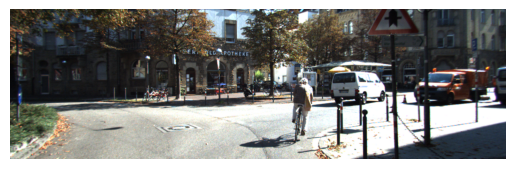

In [2]:
'''Just testing'''
img_name_list, img_list, colored_img_list = get_images(dir)
print(img_name_list[0])
plt.axis('off')
plt.imshow(colored_img_list[0][:,:,::-1])
plt.show()

In [3]:
'''
Selected Points: just use cv2 function to find points via Harris Corners, had to play around with the parameters
'''
def select_points(img0, colored_img0, img1, colored_img1):
    feature_params = dict( maxCorners = 500,
                        qualityLevel = 0.05,  
                        minDistance = 10,   
                        blockSize = 5 )

    p0 = cv2.goodFeaturesToTrack(img0,mask=None, **feature_params, useHarrisDetector=True)
    
    '''Ignore (for testing)'''
#     p0_0 = p0.astype(np.int32)
#     print("Num points:",p0.shape)
#     for i in p0_0:
#         x,y = i.ravel()
#         cv2.circle(colored_img0,(x,y),4,255,-1)
#     plt.axis('off')
#     plt.imshow(colored_img0[:,:,::-1])
#     plt.show()
#     print(colored_img0.shape)

    return p0

In [4]:
'''
Image Motion: uses cv2 Lucas Kanade func with same params as in reference, draws the motion vectors into img
              and returns the 'good' points in both imgs and image with drawn points and motion vectors
'''
def image_motion(img0, colored_img0, img1, colored_img1, p0):
    lk_params = dict( winSize  = (15, 15), 
                      maxLevel = 2, 
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)) 

    p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)

    #reverse optical flow to find p0 points again, ideally these points SHOULD be the same as original p0
    p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)

    #we find distance between p0 and p0r and determine it is an accurate point if distance < 1 pixel
    d = abs(p0-p0r).reshape(-1, 2).max(-1)
    good = d < 1
    good_p1 = p1[good].reshape(-1,2)
    good_p0 = p0[good].reshape(-1,2)
    # print(good_p1.shape)

    og = colored_img0.copy()
    vis = colored_img1.copy()

    for (x, y), (a,b) in zip(good_p1, good_p0):
        cv2.circle(vis, (int(x), int(y)), 5, 255, -1)
        cv2.line(vis, (int(a), int(b)), (int(x), int(y)), (0, 255, 0), 2)

    '''Ignore (for testing)'''
    # # vis = cv2.resize(vis, (4500,2500))
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.axis('off')
    # plt.imshow(og[:,:,::-1])

    # plt.subplot(1, 2, 2)
    # plt.axis('off')
    # plt.imshow(vis[:,:,::-1])
    # plt.show()

    return good_p0, good_p1, og, vis

In [5]:
'''
Converts the motion vectors and points into implicit lines via lecture notes process, returns list of lines
'''
def createLines(p0, p1):
    motion_vec = p1-p0
    lines = []
    for i in range(len(p0)):
        (u,v) = motion_vec[i]
        unit_norm = np.sqrt(np.square(u) + np.square(v))
        a = -v/unit_norm
        b = u/unit_norm
        c = -(a * p0[i][0] + b*p0[i][1])
        lines.append([a,b,c])
    return lines

'''
RANSAC FOE Estimation: Follows lecture notes again, estimates FOE and finds the best FOE candidate based on how
                       many lines are close to it, returns the FOE and the indices of the inliers
'''
def RANSAC(lines, samples):
    bestFOE = None
    bestCount = 0
    inlier_indices = []
    for i in range(samples):
        #finding a candidate FOE
        sample = np.random.randint(0, len(lines), 2)
        if sample[0] == sample[1]:
            continue
        A = np.array([lines[sample[0]], lines[sample[1]]])
        #SVD spits out U (left singular vec), sigma (singular val), Vh(right singular vec), we want Vh
        V = np.linalg.svd(A)[2]
        ph = V[2]
        #candidate FOE (x,y,z)
        p = ph/ph[2]
        
        lineCount = 0
        #test remaining lines on FOE
        for j in range(len(lines)):
            if j == sample[0] or j == sample[1]:
                continue
            currentLine = lines[j]
            distance = np.absolute(np.dot(currentLine, p))
            
            #threshold
            if distance < 3:
                lineCount += 1
                if j not in inlier_indices:
                    inlier_indices.append(j)
                
        if bestCount < lineCount:
            bestCount = lineCount
            bestFOE = p
            
    return bestFOE, inlier_indices

In [6]:
'''
This function just uses the previous functions and creates the first image needed for submission 
Returns FOE, good points, inliers, and the image
'''
def findFOE(img0, colored_img0, img1, colored_img1):
    p0 = select_points(img0, colored_img0, img1, colored_img1)
    good_p0, good_p1, og, vis = image_motion(img0, colored_img0, img1, colored_img1, p0)
    lines = createLines(good_p0, good_p1)
    FOE = None
    inliers = []
    if (len(lines) != 0):
        FOE, inliers = RANSAC(lines, 30)
        print("FOE:", FOE)
        if not FOE is None:
            x, y, z = FOE
            cv2.circle(vis, (int(x), int(y)), 5, (0,0,255), -1)

    return FOE, good_p0, good_p1, inliers, vis

'''
Independent Objects and Clustering: First uses the inliers to create inverted mask to find the outliers.
                                    Then format so that we have list of points and its respective motion vector.
                                    We stuff that into a distance matrix, calculated via formula in lecture notes.
                                    Now we can finally use clustering func using precomputed distance matrix.
                                    The rest is just creating bbox, drawing points and motion vectors again for final output.
'''
def independentMotion(good_p0, good_p1, inliers, img):
    mask = np.zeros(len(good_p0), dtype=bool)
    mask[inliers] = True
    pts1 = good_p0[~mask]
    pts2 = good_p1[~mask]
    motion = pts1-pts2
    X = np.concatenate((pts1, motion), axis=1)
    
    '''Custom Distance function to follow lecture func'''
    def custom_distance(point1,point2):
        u, v = point1[2], point1[3]
        u1, v1 = point2[2], point2[3]
        dot_product = u * u1 + v * v1
        img_dist = np.abs(np.array(point1[:2]) - np.array(point2[:2]))
        distance = dot_product + np.sum(img_dist)
        return distance
    
    '''Distance matrix as input to the clustering func'''
    def dist_matrix(points):
        num_points = len(points)
        distance_matrix = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(num_points):
                distance_matrix[i, j] = custom_distance(points[i], points[j])
        return distance_matrix
    
    mat = dist_matrix(X)
    cluster = AgglomerativeClustering(n_clusters=6, compute_full_tree=True,linkage='complete')
    labels = cluster.fit_predict(mat)
    
    def calculate_bounding_box(cluster_points):
        min_x = np.min(cluster_points[:, 0])
        max_x = np.max(cluster_points[:, 0])
        min_y = np.min(cluster_points[:, 1])
        max_y = np.max(cluster_points[:, 1])
        return min_x, max_x, min_y, max_y
    
    for cluster_label in np.unique(labels):
        #filters the points in the cluster
        cluster_p0 = pts1[labels == cluster_label]
        cluster_p1 = pts2[labels == cluster_label]
        min_x, max_x, min_y, max_y = calculate_bounding_box(cluster_p0)
        color = tuple(np.random.randint(0, 256, 3).tolist())
        for (x, y), (a,b) in zip(cluster_p1, cluster_p0):
            cv2.circle(img, (int(x), int(y)), 5, color, -1)
            cv2.line(img, (int(a), int(b)), (int(x), int(y)), (0, 255, 0), 2)
        cv2.rectangle(img, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 3)
        
    return img

Img 000003_10.png and Img 000003_11.png
FOE: [192.79742 158.97838   1.     ]


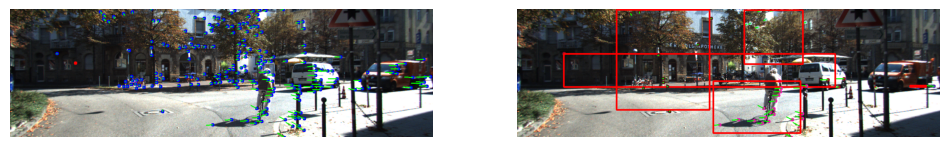


Img 000005_10.png and Img 000005_11.png
FOE: [575.8761  170.64262   1.     ]


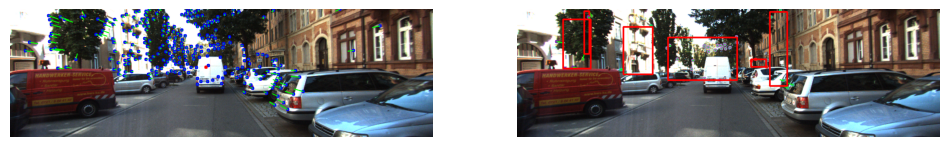


Img 000017_10.png and Img 000017_11.png
FOE: [480.1541  281.66876   1.     ]


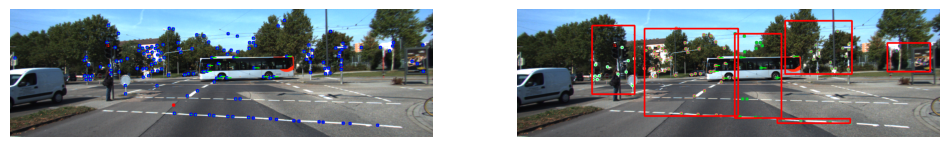


Img 000020_10.png and Img 000020_11.png
FOE: [516.3134  190.60382   1.     ]


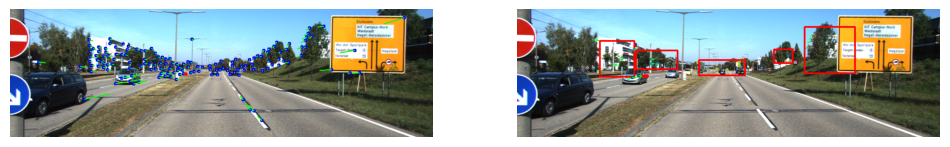


Img 000035_10.png and Img 000035_11.png
FOE: [588.1919  185.80997   1.     ]


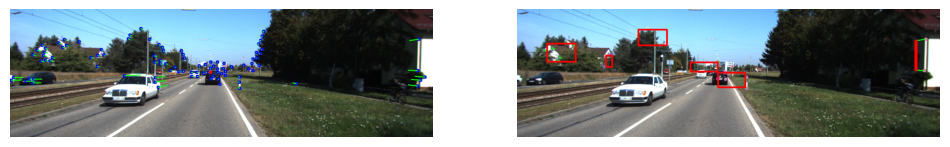


Img 000066_10.png and Img 000066_11.png
FOE: [597.5388  208.13358   1.     ]


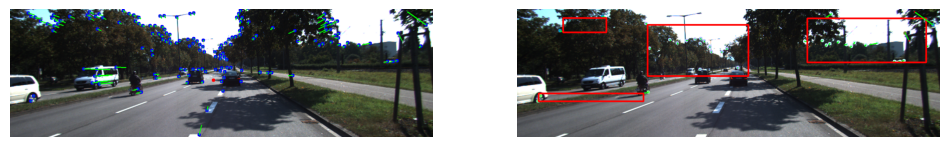


Img 000067_10.png and Img 000067_11.png
FOE: [714.7567  160.53767   1.     ]


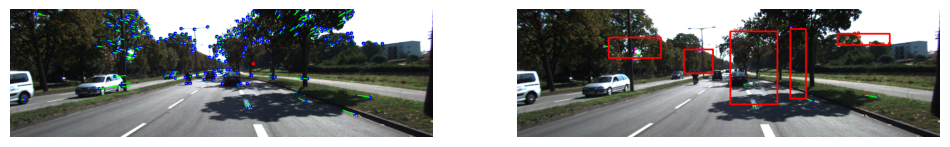


Img 000101_10.png and Img 000101_11.png
FOE: [610.0065  184.14989   1.     ]


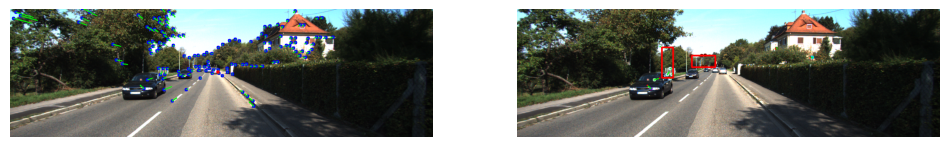


Img 000102_10.png and Img 000102_11.png
FOE: [575.37726 258.21036   1.     ]


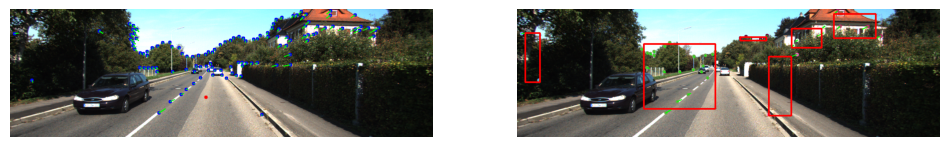


Img 000105_10.png and Img 000105_11.png
FOE: [1.01361536e+03 1.14740700e+02 1.00000000e+00]


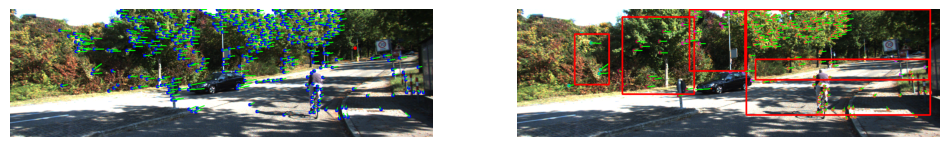


Img 000109_10.png and Img 000109_11.png
FOE: [551.7894   -28.607216   1.      ]


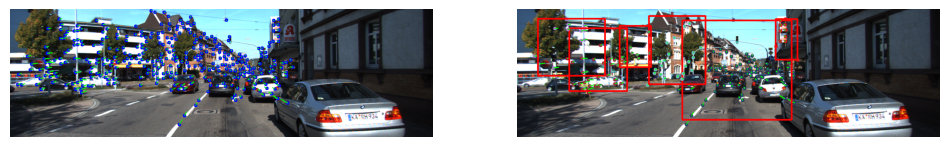


Img 000110_10.png and Img 000110_11.png
FOE: [871.0998   -57.725098   1.      ]


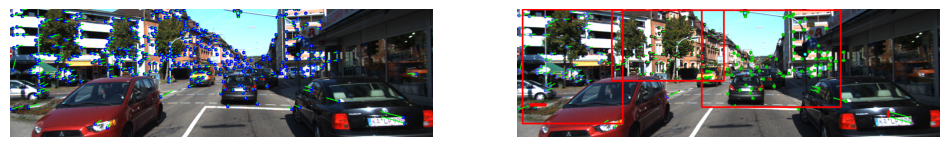


Img 000123_10.png and Img 000123_11.png
FOE: [613.08154 234.51051   1.     ]


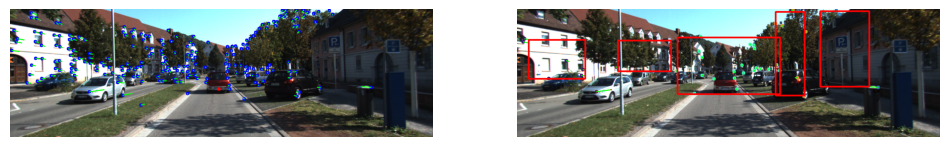


Img 000130_10.png and Img 000130_11.png
FOE: [833.8818    -2.819432   1.      ]


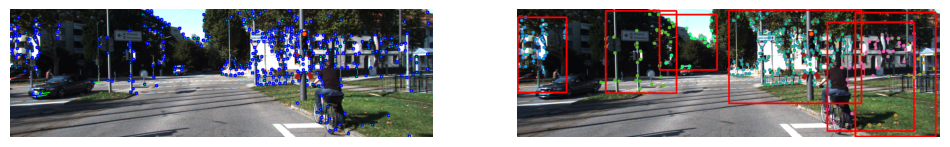


Img 000131_10.png and Img 000131_11.png
FOE: [1.1347686e+03 2.6357181e+02 1.0000000e+00]


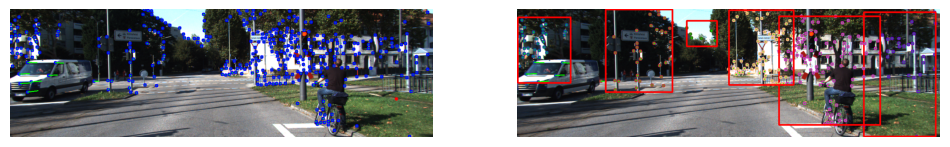


Img 000149_10.png and Img 000149_11.png
FOE: [567.20795  36.81624   1.     ]


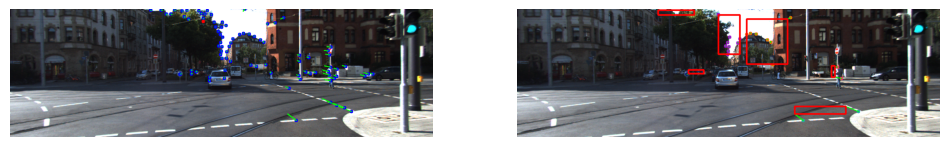


Img 000150_10.png and Img 000150_11.png
FOE: [652.96967  92.08328   1.     ]


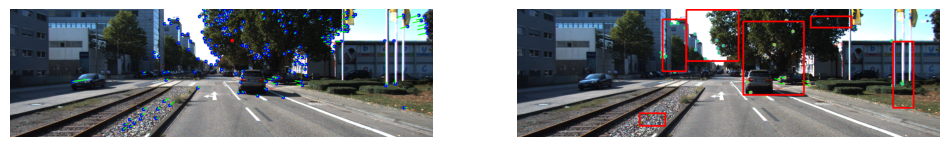


Img 000151_10.png and Img 000151_11.png
FOE: [568.29474 171.12604   1.     ]


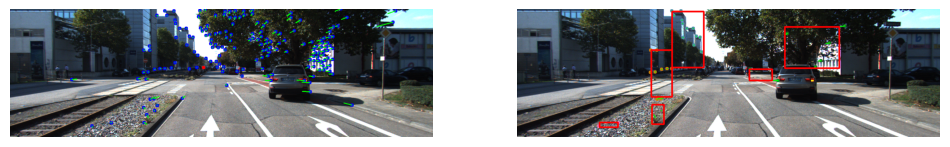


Img 000169_10.png and Img 000169_10_0.png
FOE: [703.4191   115.284134   1.      ]


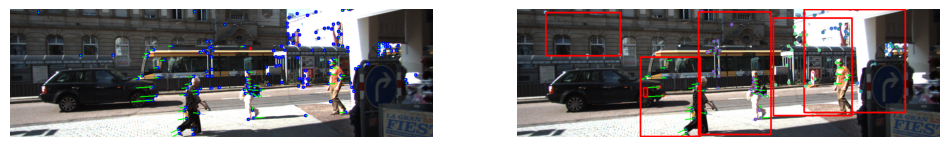


Img 000169_10_1.png and Img 000169_10_2.png
FOE: [649.7538 150.264    1.    ]


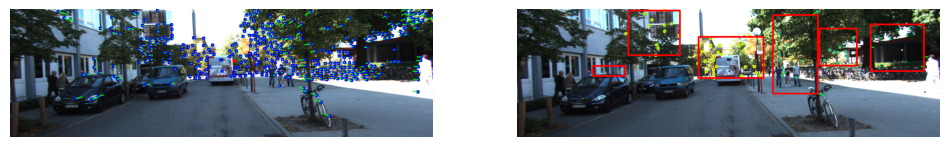


Img 000170_10.png and Img 000170_11.png
FOE: [605.7838  179.29633   1.     ]


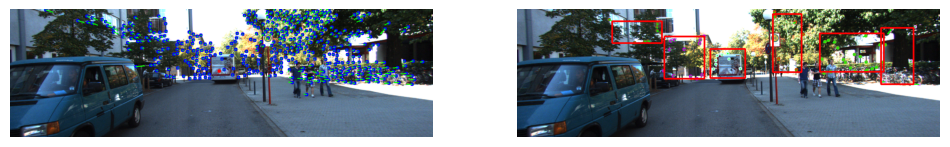


Img 000182_10.png and Img 000182_11.png
FOE: [679.83545 189.8086    1.     ]


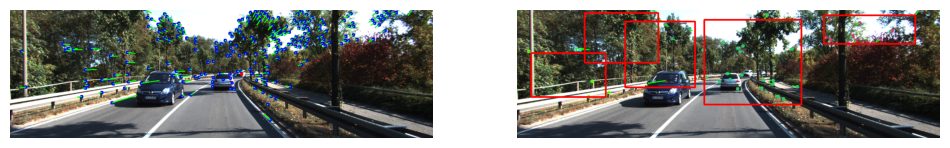


Img 000186_10.png and Img 000186_11.png
FOE: [660.5618  158.14294   1.     ]


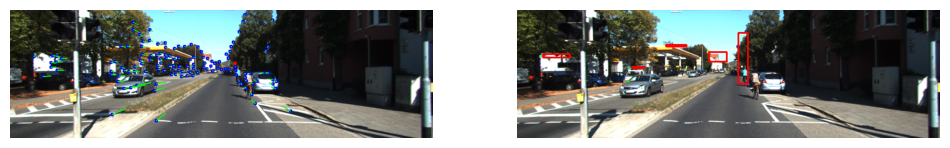


Img 000198_10.png and Img 000198_11.png
FOE: [598.1876  171.15558   1.     ]


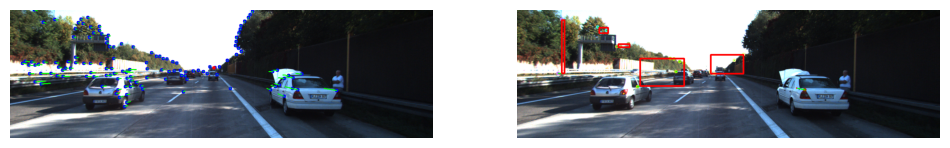


Img 000199_10.png and Img 000199_11.png
FOE: [624.6682  158.38365   1.     ]


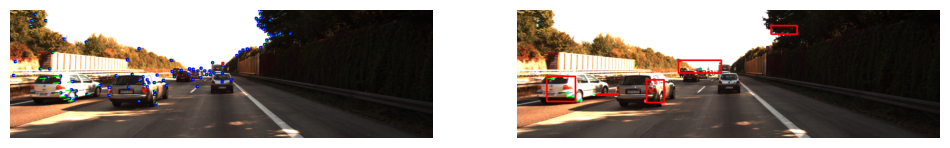

In [7]:
length = len(img_list)
for i in range(0, length-1, 2):
    print("Img", img_name_list[i], "and Img", img_name_list[i+1])
    img0, colored_img0, img1, colored_img1 = img_list[i], colored_img_list[i], img_list[i+1], colored_img_list[i+1]
    FOE, good_p0, good_p1, inliers, vis = findFOE(img0, colored_img0, img1, colored_img1)

    if not FOE is None:
        img = colored_img1.copy()
        objects = independentMotion(good_p0, good_p1, inliers, img)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(vis[:,:,::-1])

        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(objects[:,:,::-1])
        plt.show()
    print()

FOE: [644.56024 192.57608   1.     ]
Before


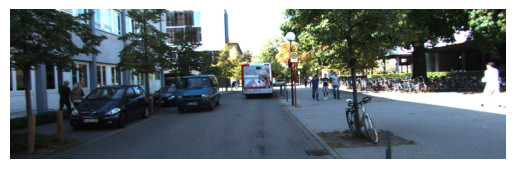

After


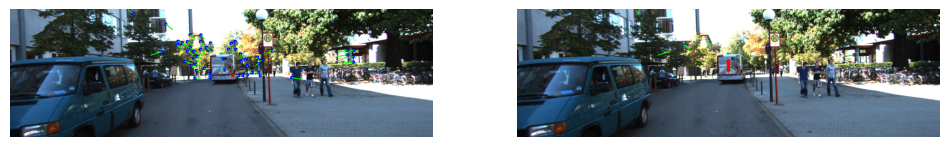

In [8]:
'''Example of when there is a large translation (sucks)'''
img0 = img_list[len(img_list) - 12]
colored_img0 = colored_img_list[len(img_list) - 12].copy()

img1 = img_list[len(img_list) - 9]
colored_img1 = colored_img_list[len(img_list) - 9].copy()

FOE, good_p0, good_p1, inliers, vis = findFOE(img0, colored_img0, img1, colored_img1)
print("Before")
plt.axis('off')
plt.imshow(colored_img0[:,:,::-1])
plt.show()

if not FOE is None:
    img = colored_img1.copy()
    objects = independentMotion(good_p0, good_p1, inliers, img)
    print("After")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(vis[:,:,::-1])

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(objects[:,:,::-1])
    plt.show()